In [1]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import matplotlib.patheffects as pe
# for exporting things as mat for matlab
import scipy.io

# For linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic
)

# For kernel covariance matrix
import seaborn as sns

In [2]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#1E77B4','#FCAF38',"#BFD061"] #Color scheme
USGS_site_id = ['05325000','05325300','05330000']
markers = ['s', 'o','^', 'D']
labels = list(string.ascii_uppercase)
alpha_site_id = labels[0:len(USGS_site_id)]

plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

# Load USGS data

In [3]:
#Load USGS data
# numbers for easy enumeration
site_numbs = np.arange(len(USGS_site_id))
# updates ADVM and grab_samples readings to included calculated SAC and SSC already and calucated dq/dt for samples
ADVM_readings = create_USGS_dfs('sensor', USGS_site_id) #Sensor readings for all sites
Grab_samples = create_USGS_dfs('samples', USGS_site_id) #Grab samples and flow for all sites
Qall_time = create_USGS_dfs('Qall', USGS_site_id) #Discharge for total time range of sensor deployment per site


dfc = pd.read_csv(r'USGS_data/USGS_site_consts.csv') # Read in constants for all sites
dfc['Site_ID'] = dfc['Site_ID'].map(toName) #Converts Site_ID to string type

data_dictionary = {} # empty dictionary to put dataframes into, keys are site id
for i, id in enumerate(USGS_site_id):
    #Selects constants for each USGS site
    Consts = dfc.loc[dfc['Site_ID'] ==  id].iloc[0, 1:]

    data_dictionary[alpha_site_id[i]] = { 'USGS_id' : id,
                            'ADVM' : ADVM_readings[id],
                            'Samples' : Grab_samples[id],
                            'Flow' : Qall_time[id],
                            'Consts' : Consts # This is a pandas series
                        }

# Run GP baseline for each site

In [4]:
# run GP

def extract_kernel_hyperparams(kernel):
    params = {}
    all_params = kernel.get_params()

    for name, val in all_params.items():
        # Only keep float/numeric hyperparameters (not subkernels)
        if isinstance(val, (float, int, np.float64, np.int64)):
            params[name] = val

    return params

# Gaussian Process Regression function

def GP(SAC_m, SSC_m, p, SAC_log=False, SSC_log=False, hyperparams=-999):
    # ---- Normalize x using min-max ----
    min_SAC = SAC_m.min()
    max_SAC = SAC_m.max()
    x_range = max_SAC - min_SAC
    if x_range < 1e-8:
        raise ValueError("Input x has too small a range to normalize reliably.")
    X = ((SAC_m - min_SAC) / x_range).reshape(-1, 1)

    # ---- Normalize y using min-max ----
    min_SSC = SSC_m.min()
    max_SSC = SSC_m.max()
    y_range = max_SSC - min_SSC
    if y_range < 1e-8:
        raise ValueError("Target y has too small a range to normalize reliably.")
    y = ((SSC_m - min_SSC) / y_range).reshape(-1, 1)

    if SAC_log:
        X = np.log10(X + 1e-8)
    if SSC_log:
        y = np.log10(y + 1e-6)

    # Kernel setup
    input_mean = np.abs(np.mean(X))
    noise_std = max(np.std(y), 1e-6)

    if hyperparams == -999:
        kernel = (
            ConstantKernel(0.3, (0.05, 0.8)) *
            RBF(length_scale=0.5, length_scale_bounds=(0.3, 2)) 
            # DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1 , 2))
            # RationalQuadratic(length_scale=0.5, length_scale_bounds=(0.3, 1),
            #                  alpha=1.0, alpha_bounds=(0.1, 100.0)) 
        )
    else:
        l = hyperparams[0]
        kernel = RBF(l, length_scale_bounds="fixed")

    SAC_pred = np.linspace(0, 1, p).reshape(-1, 1)

    # Fit with cross-validated alpha
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    # since envrionmental data, trying to find best alpha (noise) but have it not be too low
    alphas = np.logspace(-2, -1, 10)
    search = GridSearchCV(gp, {'alpha': alphas}, cv=min(5, len(X)))
    search.fit(X, y.ravel())

    best_alpha = search.best_params_['alpha']
    gp_best = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=best_alpha)
    gp_best.fit(X, y.ravel())

    Y_pred_scaled, std_scaled = gp_best.predict(SAC_pred, return_std=True)

    # Invert y-scaling
    Y_pred_orig = Y_pred_scaled * y_range + min_SSC
    std_orig = std_scaled * y_range

    # Invert x-scaling for plotting
    SAC_pred_orig = SAC_pred.ravel() * x_range + min_SAC

    score = gp_best.score(X, y.ravel())
    log_marg = gp_best.log_marginal_likelihood()

    return SAC_pred_orig, Y_pred_orig, std_orig, score, log_marg, gp_best, best_alpha, (min_SAC, x_range), (min_SSC, y_range)


# Example usage (replace with your actual loop logic)
model_dictionary = {}
x_key = 'SAC'
y_key = 'SSC'

for i, site_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]['Samples']
    # print(site_data.keys())
    # print(site_data.keys())
    
    # Scatter plot
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])
    print(site_id, xdata, ydata)

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model, n_alpha, x_scale, y_scale = GP(xdata, ydata, p)
    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
    x_min, x_range = x_scale
    x_scaled = (xdata - x_min) / x_range
    ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)
    
    y_min, y_range = y_scale
    ypred = ypred_scaled * y_range + y_min
    std_pred = std_pred_scaled * y_range

    MSE_all = np.square(np.subtract(ydata, ypred)).mean()
    rmse_all = math.sqrt(MSE_all)
    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))
    print(f"Site {site_id} - RMSE: {rmse_all:.2f}, R^2: {r_score_all:.2f}, Alpha: {n_alpha}")

    model_dictionary[site_id] = {
        'hyperparams': kernel_params,
        'num_samp': len(xdata),
        'x': xdata,
        'y': ydata,
        'n_pred': ypred,
        'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
        'scores': {
            'GP_score': GP_score_all,
            'GP_logmarg': GP_logmarg_all,
            'r_score': r_score_all,
            'rmse': rmse_all,
            'std': std_pred,
            'alpha': n_alpha,
        },
        'model': GP_model,
        'x_scaling': x_scale,  # (min_SAC, x_range)
        'y_scaling': y_scale,  # (min_SSC, y_range)
    }



A [1.26721015 1.32127946 1.31394716 0.80759126 0.54584746 0.71134633
 1.22040495 0.69722757 0.52350769 1.59055352 1.37598444 1.03334167
 0.60315934 0.74045886 1.08146695 1.14763104 1.07011739 1.21238934
 0.50779616 1.11103744] [ 386.   287.   366.   222.   137.5  241.   520.   306.   176.  1191.
 1150.   503.   145.   139.   308.   364.   351.   446.    66.   833. ]
Site A - RMSE: 214.67, R^2: -1.78, Alpha: 0.1
B [1.26567704 1.32183596 1.21300983 0.91092152 0.72643172 0.6535379
 1.22438573 0.91187757 0.7291864  0.71611927 1.98931588 1.65204932
 0.98544044 0.87003789 0.94392123 1.2592935  1.30139913 1.31298998
 1.38638257 1.25423791 0.56555196 1.35604495] [ 305  332  360  246  173  188  565  332  189  128 1620  930  344  195
  204  296  344  352  418  365   83  781]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

Site B - RMSE: 100.92, R^2: -1.45, Alpha: 0.01
C [0.79102913 0.84256709 0.78471862 0.50370576 0.55501959 1.68865786
 0.45561461 0.50052758 0.41172928 0.38068765 0.5002159  0.4440302
 0.63347193 0.74425062 0.91018902 0.8125168  0.88188531 0.93698205
 0.40676942 0.77960587 0.71733819] [ 268  312  381  174  247 1390  343  240  210   67  147  180  234  330
  406  411  627  538   81  570  615]
Site C - RMSE: 104.42, R^2: -1.76, Alpha: 0.01


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

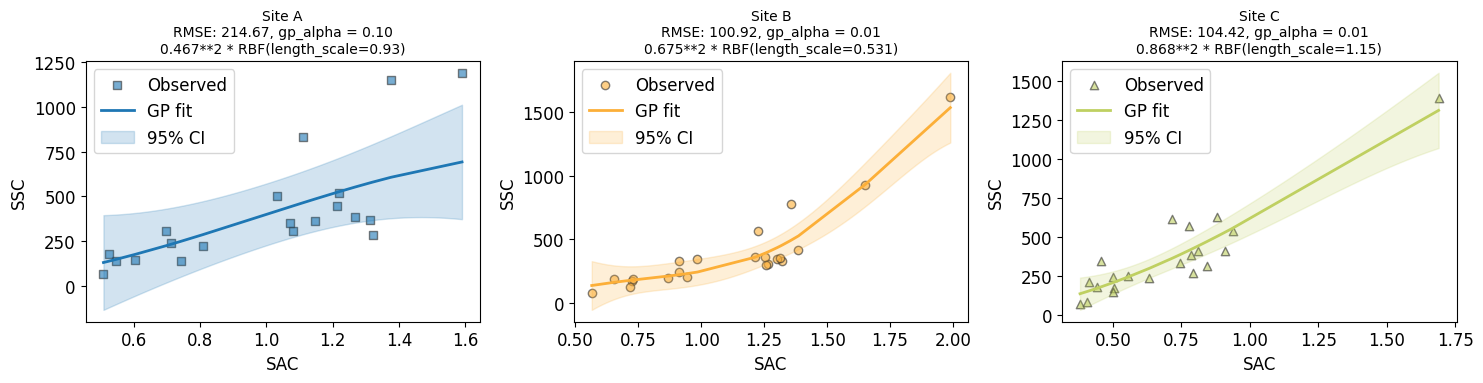

In [5]:
x_key = 'SAC'
y_key = 'SSC'

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 3
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    gp_alpha = model['scores']['alpha']

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)
    ax.fill_between(SAC_pred_all,
                SSC_pred_all - 1.96 * std_all,
                SSC_pred_all + 1.96 * std_all,
                color=color, alpha=0.2, label='95% CI')

    try:
        kernel_str = str(model['model'].kernel_)
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha:.2f}\n{kernel_str}",
        fontsize=10
    )

    # ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Compute correlation matricies

In [6]:
def const_rbf_kernel(x, y, length_scale, const):
    rbf = math.exp(- math.dist([x],[y]) / (2*length_scale**2) )
    return const * rbf

def cov_to_cor(cov):
    d = np.sqrt(np.diag(cov))
    return cov / np.outer(d, d)

correlation_matrices = {}
n_range = [20, 25, 50, 100]

for id in alpha_site_id:
    correlation_matrices[id] = {}
    mod = model_dictionary[id]
    x = np.array(mod['x'])
    y = np.array(mod['y'])
    pred_x = mod['p_pred'][0]
    pred_y = mod['p_pred'][1]

    # Hyperparameters 
    hp = mod['hyperparams']
    print(hp)
    const = hp.get('k1__constant_value', None)
    l = hp.get('k2__length_scale', None)


    if l is None or const is None:
        raise ValueError(f"Missing hyperparameter in site {id}")


    # Sort input data
    ord = np.argsort(x)
    x_sort = x[ord]
    y_sort = y[ord]

    # Raw range
    x_min = np.min(x_sort)
    x_max = np.max(x_sort)

    x_sort_scaled = (x_sort - x_min) / (x_max - x_min)

    # --- Fixed range, variable number of prediction points ---
    correlation_matrices[id]['n'] = {}
    for n in n_range:
        # since models trained scaled to 0 to 1, use same range
        nx_trend_scaled = np.linspace(0, 1, n)
        kern = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                kern[i, j] = const_rbf_kernel(nx_trend_scaled[i], nx_trend_scaled[j], l, const)
        cor_mat = cov_to_cor(kern)

        correlation_matrices[id]['n'][n] = {
            'hyperparams': {
                'length_scale': l,
                'constant_value': const,
            },
            'cor_matrix': cor_mat,
            'range': nx_trend_scaled * (x_max - x_min) + x_min,  # Rescale to original range
            'range_scaled': nx_trend_scaled,
        }

    # --- Across sites: use each model's kernel on this site's inputs ---
    correlation_matrices[id]['num_samp'] = {}
    for model_id in alpha_site_id:
        # get model hyperparemeter to use at site id
        # Hyperparameters (decoded with exp)
        hp_mod = model_dictionary[model_id]['hyperparams']
        const_mod = hp_mod.get('k1__constant_value', None)
        l_mod = hp_mod.get('k2__length_scale', None)
        samp_n = len(x_sort_scaled)

        kern = np.zeros((samp_n, samp_n))
        # use scaled x_sort for consistency with model training
        for i in range(samp_n):
            for j in range(samp_n):
                kern[i, j] = const_rbf_kernel(x_sort_scaled[i], x_sort_scaled[j], l_mod, const_mod)
        cor_mat = cov_to_cor(kern)
        print(l_mod, const_mod, id, site_id, model_id, samp_n, x_sort_scaled[0], x_sort_scaled[-1])

        correlation_matrices[id]['num_samp'][model_id] = {
            'hyperparams': {
                'length_scale': l_mod,
                'constant_value': const_mod,
            },
            'cor_matrix': cor_mat,
            'range': x_sort,
            'range_scaled': x_sort_scaled,
            'n': samp_n,
        }
        print(correlation_matrices[id]['num_samp'][model_id]['cor_matrix'].shape, id, model_id)


{'k1__constant_value': 0.21854947117839632, 'k2__length_scale': 0.9299884422355191}
0.9299884422355191 0.21854947117839632 A C A 20 0.0 1.0
(20, 20) A A
0.5310235349921094 0.4555117039193293 A C B 20 0.0 1.0
(20, 20) A B
1.145973716945598 0.7540924505039557 A C C 20 0.0 1.0
(20, 20) A C
{'k1__constant_value': 0.4555117039193293, 'k2__length_scale': 0.5310235349921094}
0.9299884422355191 0.21854947117839632 B C A 22 0.0 1.0
(22, 22) B A
0.5310235349921094 0.4555117039193293 B C B 22 0.0 1.0
(22, 22) B B
1.145973716945598 0.7540924505039557 B C C 22 0.0 1.0
(22, 22) B C
{'k1__constant_value': 0.7540924505039557, 'k2__length_scale': 1.145973716945598}
0.9299884422355191 0.21854947117839632 C C A 21 0.0 1.0
(21, 21) C A
0.5310235349921094 0.4555117039193293 C C B 21 0.0 1.0
(21, 21) C B
1.145973716945598 0.7540924505039557 C C C 21 0.0 1.0
(21, 21) C C


In [7]:
print(kern.shape, cor_mat.shape)

print(cor_mat)

(21, 21) (21, 21)
[[1.         0.99243668 0.99100489 0.98173075 0.97842586 0.9658052
  0.96571758 0.96482458 0.9505203  0.92905975 0.9066538  0.89957895
  0.89036845 0.88904434 0.88741275 0.8818795  0.87419912 0.86425092
  0.85715975 0.85050067 0.68336022]
 [0.99243668 1.         0.99855729 0.98921248 0.9858824  0.97316556
  0.97307727 0.97217747 0.95776417 0.93614008 0.91356337 0.9064346
  0.89715391 0.89581971 0.89417568 0.88860026 0.88086135 0.87083734
  0.86369213 0.8569823  0.68856808]
 [0.99100489 0.99855729 1.         0.99064169 0.9873068  0.97457158
  0.97448317 0.97358206 0.95914794 0.93749261 0.91488328 0.90774421
  0.89845011 0.89711398 0.89546758 0.8898841  0.88213401 0.87209552
  0.86493998 0.85822046 0.68956292]
 [0.98173075 0.98921248 0.99064169 1.         0.99663361 0.98377809
  0.98368884 0.98277922 0.96820874 0.94634883 0.92352592 0.91631941
  0.90693752 0.90558876 0.90392681 0.89829059 0.89046728 0.88033396
  0.87311083 0.86632783 0.69607703]
 [0.97842586 0.9858824  

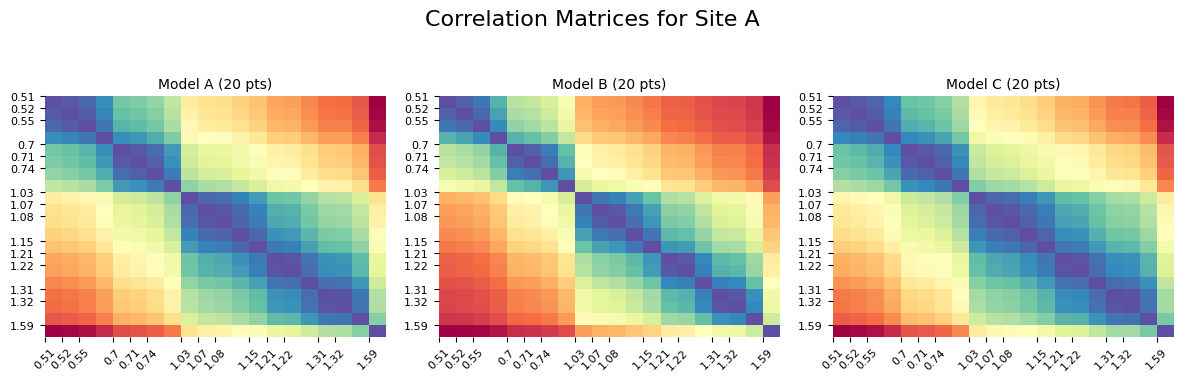

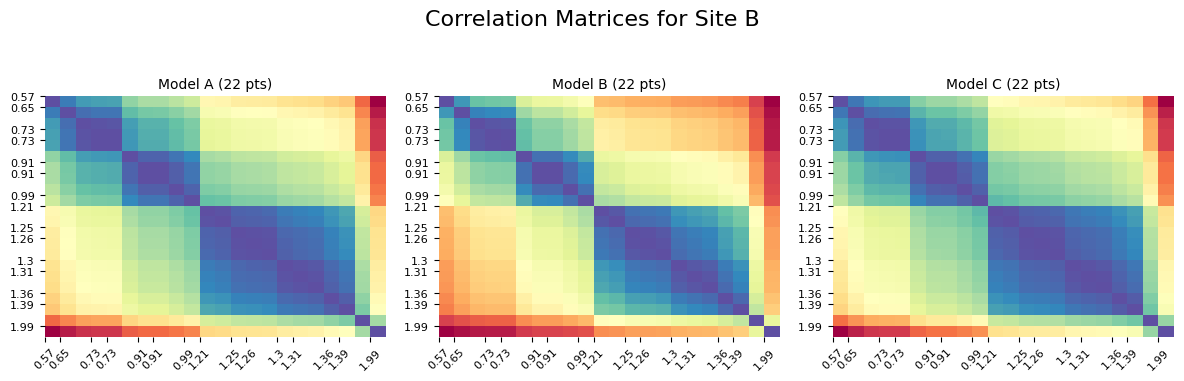

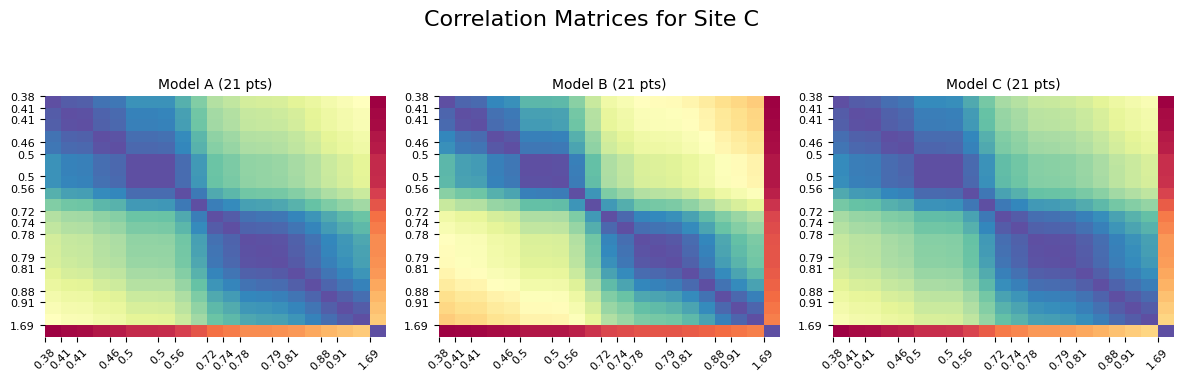

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for id, models in correlation_matrices.items():
    num_models = len(models['num_samp'])
    num_plots = num_models
    nrows, ncols = 1, num_models  # Adjusted to fit all models in one row

    fig, axes = plt.subplots(nrows, ncols, figsize=(4* n_cols, 4* n_rows))
    axes = axes.flatten()

    for index, (model_id, data) in enumerate(models['num_samp'].items()):
        if index >= len(axes):
            break

        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        n_points = len(nx_trend)

        # Decide whether to annotate or use tick labels based on matrix size
        show_ticks = n_points <= 20
        xticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        yticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        nx_trend_sorted = np.sort(nx_trend)  # make sure x is sorted

        # Decide how many ticks to show (15 or fewer)
        n_total = len(nx_trend_sorted)
        n_ticks = min(15, n_total)

        # Get tick indices evenly spaced by index
        tick_indices = np.linspace(0, n_total - 1, n_ticks, dtype=int)
        tick_labels = np.round(nx_trend_sorted[tick_indices], 2)

        sns.heatmap(
            cor_mat,
            cbar=False,
            annot=False,  # turn on if n_points is small and needed
            cmap="Spectral",
            fmt='.2f',
            ax=axes[index],
            xticklabels=False,
            yticklabels=False
        )
        axes[index].set_title(f'Model {model_id} ({n_points} pts)', fontsize=10)
        # Set manual ticks and labels
        axes[index].set_xticks(tick_indices)
        axes[index].set_xticklabels(tick_labels, rotation=45, fontsize=8) 


        axes[index].set_yticks(tick_indices)
        axes[index].set_yticklabels(tick_labels, fontsize=8)

    # Hide any unused axes
    for j in range(index + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Correlation Matrices for Site {id}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # Optional: save to file
    # plt.savefig(f'correlation_matrices_site_{id}.png', dpi=150)
    plt.close()


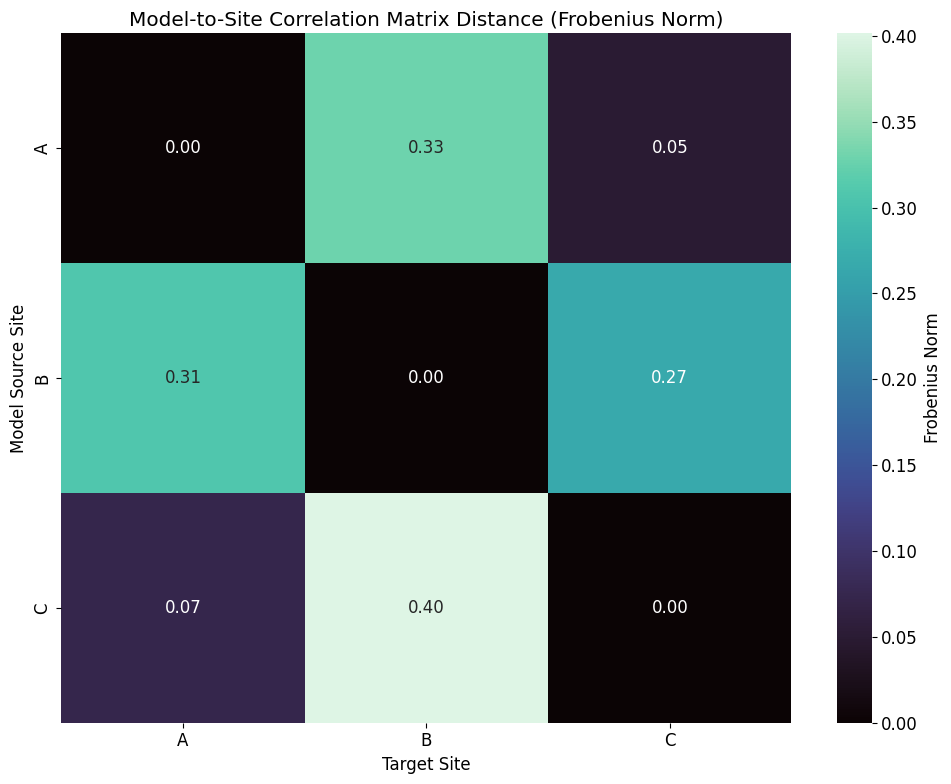

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

site_ids = list(correlation_matrices.keys())
n_sites = len(site_ids)

# Frobenius distance matrix (models vs sites)
fro_rel_matrix = np.zeros((n_sites, n_sites))

for i, model_site in enumerate(site_ids):
    for j, target_site in enumerate(site_ids):
        try:
            # Model from model_site, applied to target_site
            A = correlation_matrices[target_site]['num_samp'][model_site]['cor_matrix']

            # Reference matrix: model trained & applied on target_site itself
            B = correlation_matrices[target_site]['num_samp'][target_site]['cor_matrix']
            n = B.shape[0]

            # Option 1: normalized by sqrt(n)
            norm_diff = np.linalg.norm(A - B, 'fro') / np.sqrt(n)

            # Option 2: relative to reference matrix norm
            ref_norm = np.linalg.norm(B, 'fro')
            rel_diff = np.linalg.norm(A - B, 'fro') / ref_norm if ref_norm != 0 else np.nan

            fro_rel_matrix[i, j] = rel_diff  # use rel_diff or norm_diff

        except KeyError:
            continue  # Leave as NaN if matrix doesn't exist

plt.figure(figsize=(10, 8))
sns.heatmap(fro_rel_matrix, annot=True, fmt=".2f", cmap="mako", 
            xticklabels=site_ids, yticklabels=site_ids, cbar_kws={'label': 'Frobenius Norm'})

plt.xlabel("Target Site")
plt.ylabel("Model Source Site")
plt.title("Model-to-Site Correlation Matrix Distance (Frobenius Norm)")
plt.tight_layout()
plt.show()



# Matlab OMP calculation

## Save correlation mat for matlab

In [10]:
MATLAB_FILEPATH = "GVR_USGS"
MATLAB_FILEPATH_ALLSAMP = MATLAB_FILEPATH + "/all_samp"
MATLAB_FILEPATH_ALLSAMP_N = MATLAB_FILEPATH_ALLSAMP + "/n_point"   
# do this to get the cor matrix
for id, models in correlation_matrices.items():
    print(f"data set: ")
    
    
    for model_id, data in models['num_samp'].items():
        # print("model_id:" , model_id)
        cor_mat = data['cor_matrix']
        nx_trend = data['range_scaled']
        
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP}/corr_samp{id}{model_id}.mat', {'cor_mat': cor_mat})
    scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP}/xdata_scaled_samp{id}.mat', {'xdata': nx_trend})
    
    
    
    # save n samples too
    for n, data in models['n'].items():
        # print("num_points:" , n)
        cor_mat = data['cor_matrix']
        nx_trend = data['range_scaled']
        
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP_N}/xdata_scaled_range{id}{n}.mat', {'xdata': nx_trend})
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP_N}/corr_range{id}{n}.mat', {'cor_mat': cor_mat})
        


data set: 
data set: 
data set: 


## Read OMP selection from Matlab

In [11]:
""" read sample selection and scores given arbritrary SAC range """
range_selection = {}

for id in alpha_site_id:
    range_selection[id] = {}
    for n in n_range:
        range_selection[id][n] = {}
        dict = range_selection[id][n]
        mat_file = scipy.io.loadmat(f'{MATLAB_FILEPATH_ALLSAMP_N}/range{id}{n}.mat')
        dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        dict['score'] = mat_file['scores'][0]

""" read in sample selection out of grab samples we already have (permutating through each correlation matrix that was used to select samples) """
grabSamp_selection = {}

# selects site with grab samples used
for id in alpha_site_id:
    grabSamp_selection[id] = {}
    # cycle through kernel used
    for model_id in alpha_site_id:
        grabSamp_selection[id][model_id] = {}
        dict = grabSamp_selection[id][model_id] 
        mat_file = scipy.io.loadmat(f'{MATLAB_FILEPATH_ALLSAMP}/samp{id}{model_id}.mat')
        dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        dict['score'] = mat_file['scores'][0]


## Plot Elbow Curve

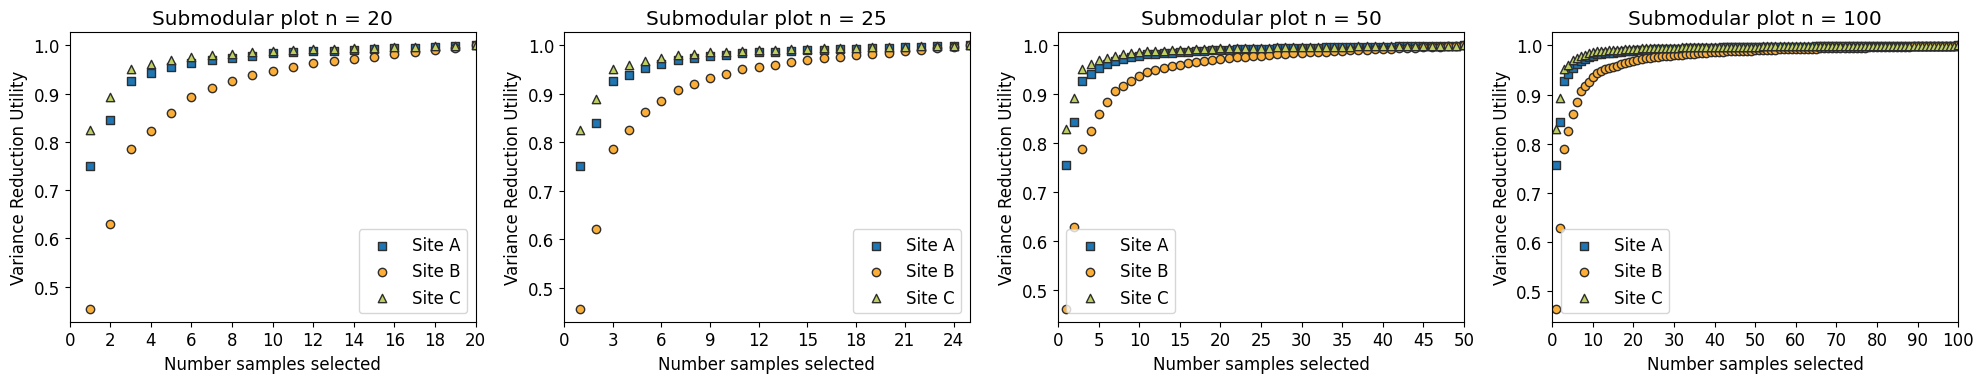

In [12]:
# Plotting the curves with subplots for each item in n_range
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, n in enumerate(n_range):
    if idx >= len(axes):
        break  # In case n_range has more than 4 items

    ax = axes[idx]
    for i, id in enumerate(alpha_site_id):
        dict_data = range_selection[id][n]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('Variance Reduction Utility')
    ax.set_title(f'Submodular plot n = {n}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if n_range has less than 4 items
for i in range(len(n_range), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

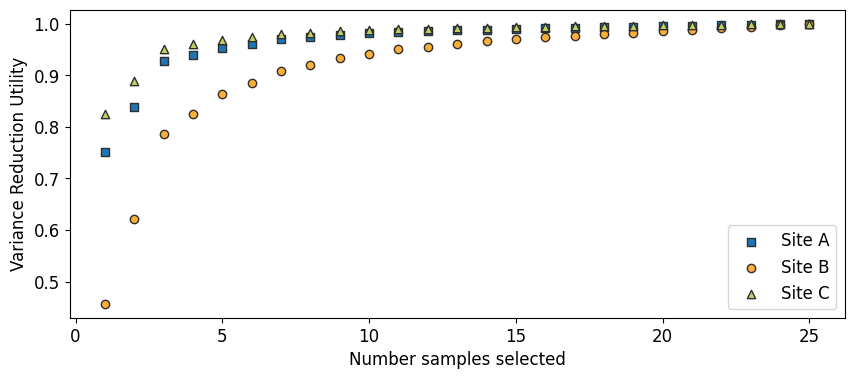

In [13]:
# plot only for n = 25

fig, ax = plt.subplots(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    dict_data = range_selection[id][25]
    samples = dict_data['samples']
    scores = dict_data['score']
    
    # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
    x_axis = range(1, len(samples) + 1)
    
    # Plot the curve, preserving the relationship between samples and scores
    ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')


ax.set_xlabel('Number samples selected')
ax.set_ylabel('Variance Reduction Utility')
ax.legend()
# plt.savefig('figures/submod_n25.png', dpi=500)

## Elbows with actual field samples

A C plotted
B C plotted
C C plotted


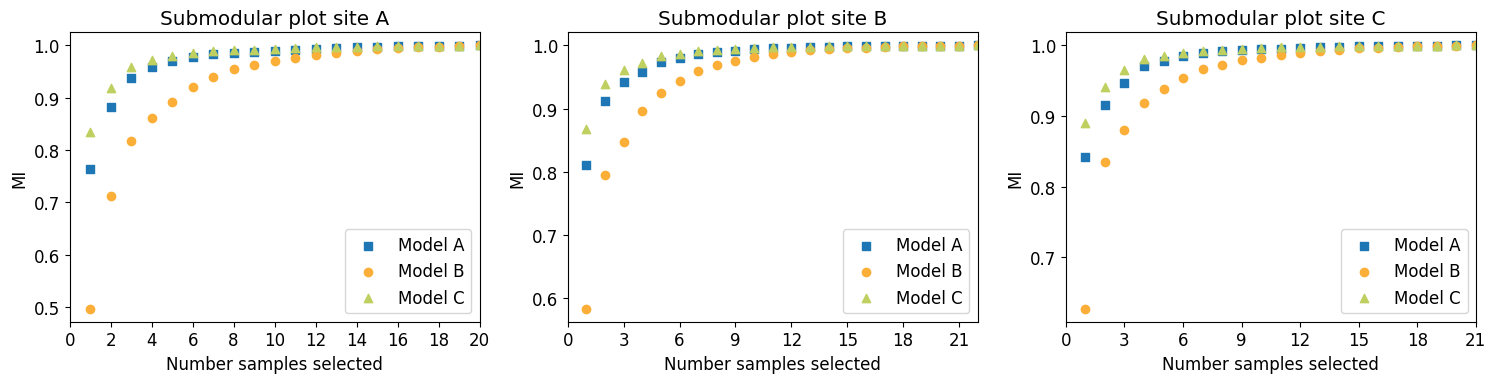

In [14]:
# Plotting the curves with subplots for each item in n_range
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for i, model_id in enumerate(alpha_site_id):
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Model {model_id}')
    print(id, model_id, 'plotted')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('MI')
    ax.set_title(f'Submodular plot site {id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if alpha_site_id has less than 3 items
for i in range(len(alpha_site_id), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Error Plots
## Calculating for optimal selection
### Start at 2 samples to train and increase to 80% of available samples

In [15]:
# make array of sample order 
for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for model_id in alpha_site_id:
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']

        print(samples)

[10  2 17  5 19 13  7  0 18  8 12  3 15  6 11  4  1  9 14 16]
[11  3 17  6 19  1 14  8  7 18  4  9 15 12  2  0  5 10 13 16]
[10  2 17  5 19 13  7  0 18  8 12  3 15  6 11  4  1  9 14 16]
[11  3 21  7 17  0 20  9 19 13  1  5  8 15 18 10  2 14 16 12  4  6]
[13  3  7 21 18  0 20  9 10 16  1  5 19  8 15  2 11 17 14 12  4  6]
[11  3 21  7 17  0 20  9 19 13  1  5  8 15 18 10  2 14 16 12  4  6]
[10  3 18 20 14  6  1  9 16  8 19  0 11 17 15 12  4  2  7 13  5]
[12  4 20 18  7  1  9 16 10  8 19  0 15 17 11  3 14  5  2 13  6]
[10  3 20 17  6 13  1 19  9  8 16  0 11 15 18  4 14 12  2  7  5]


In [16]:
optimal_dictionary = {}
sample_limit_fraction = 0.8

for i, site_id in enumerate(alpha_site_id):
    # site_data = data_dictionary[site_id]
    # all model data
    all_data = model_dictionary[site_id]
    all_x = all_data['x']
    all_y = all_data['y']
    num_total = len(all_x)
    sample_limit = int(np.ceil(num_total * sample_limit_fraction))

    baseline_rmse = all_data['scores']['rmse']
    baseline_r2 = all_data['scores']['r_score']
    # Hyperparameters 
    hp = all_data['hyperparams']
    print(hp)
    baesline_const = hp.get('k1__constant_value', None)
    baseline_l = hp.get('k2__length_scale', None)

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]


    optimal_dictionary[site_id] = { 'baseline_hyperparams': {
                                        'length_scale' : baseline_l,
                                        'constant_value' : baesline_const,
                                    },
                                    'x_sort' : all_x_sort,
                                    'y_sort' : all_y_sort,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
                                    'num_total': num_total,
                                    'sample_limit': sample_limit,
    }

    for model_id in alpha_site_id:
        opt_select = grabSamp_selection[site_id][model_id]

        opt_select = {
                        'opt_order' : opt_select['samples']
                    }

        opt_samp = opt_select['opt_order']
        print(f'length of samples: {len(opt_samp)}')
        # initialize optimal_dicitionary 
        optimal_dictionary[site_id][model_id] = {}


        # leave 20% of samples for testing
        for n in np.arange(2,sample_limit):
            opt_x = all_x_sort[opt_samp[0:n]]
            opt_y = all_y_sort[opt_samp[0:n]]
            test_x = all_x_sort[opt_samp[n:]]
            test_y = all_y_sort[opt_samp[n:]]
            # print(f'length of optx: {len(opt_x)}; n: {n}, length of test: {len(test_x)}')

            # train model using only optimal samples
            SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model, n_alpha, x_scale, y_scale  = GP(opt_x, opt_y, p) 
            kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
            x_min, x_range = x_scale
            x_scaled = (test_x - x_min) / x_range
             # important ypred and ydata are sorted same order wrt xdata
            ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)  

            y_min, y_range = y_scale
            ypred = ypred_scaled * y_range + y_min
            std_pred = std_pred_scaled * y_range   

            MSE_opt = np.square(np.subtract(test_y,ypred)).mean() 
            rmse_opt = math.sqrt(MSE_opt)

            r_score_opt = GP_model.score(ypred.reshape(-1, 1),test_y.reshape(-1, 1))

            optimal_dictionary[site_id][model_id][n] = {    'hyperparams': kernel_params,
                                                            'x_train' : opt_x,
                                                            'y_train' : opt_y,
                                                            'x_test' : test_x,
                                                            'y_test' : test_y,
                                                            'n_pred' : ypred,
                                                            'p_pred' : [SAC_pred_opt, SSC_pred_opt, std_opt],
                                                            'scores': {
                                                                'GP_score':GP_score_opt, 
                                                                'GP_logmarg':GP_logmarg_opt,
                                                                'r_score': r_score_opt, 
                                                                'rmse' : rmse_opt, 
                                                                'std': std_pred,
                                                            },
                                                            'model' : GP_model,
                                                        }

{'k1__constant_value': 0.21854947117839632, 'k2__length_scale': 0.9299884422355191}
length of samples: 20


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regre

length of samples: 20


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regre

length of samples: 20


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regre

{'k1__constant_value': 0.4555117039193293, 'k2__length_scale': 0.5310235349921094}
length of samples: 22


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__le

length of samples: 22


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

length of samples: 22


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression

{'k1__constant_value': 0.7540924505039557, 'k2__length_scale': 1.145973716945598}
length of samples: 21


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regress

length of samples: 21


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

length of samples: 21


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__co

Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted


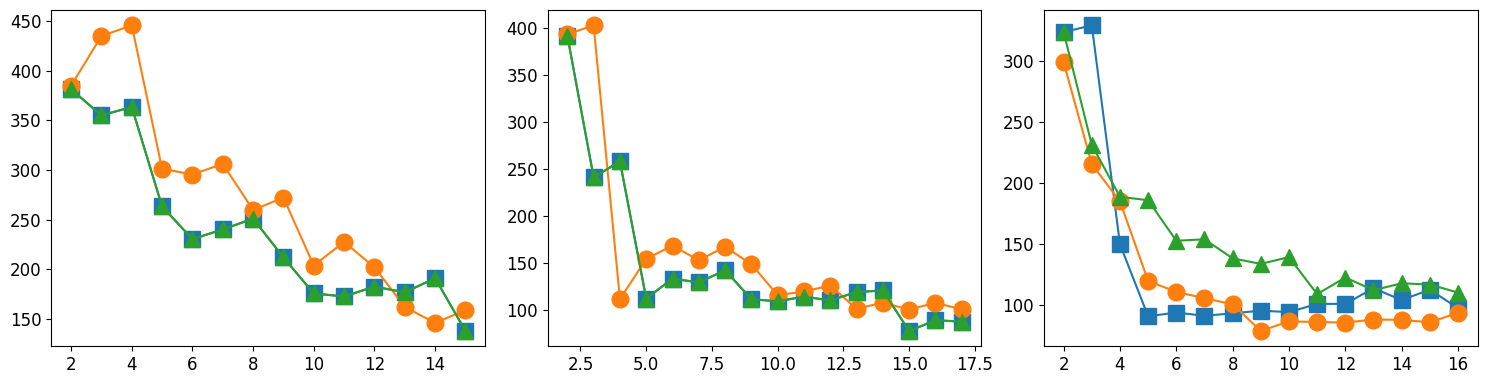

In [17]:
# Plotting the curves with subplots for each site in optimal_dictionary and random_dictionary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()


for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    for i, model_id in enumerate(alpha_site_id):
        if model_id not in optimal_dictionary[site_id]:
            continue
        
        rmses = []
        sample_counts = []
        
        for n in sorted(optimal_dictionary[site_id][model_id].keys()):
            rmse = optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            rmses.append(rmse)
            sample_counts.append(n)
        
        # Plot the curve
        ax.plot(sample_counts, rmses, linestyle='-', label=f'OMP {model_id}', marker = markers[i], markersize = '12')
        print(f'Site {site_id}, Model {model_id} plotted')

    sample_size = len(optimal_dictionary[site_id]['x_sort'])
    base_rmse = optimal_dictionary[site_id]['baseline_rmse']
    # ax.plot(range(sample_size), np.ones(sample_size)*base_rmse, color = 'red', linewidth = 3, label='baseline RMSE')

# Hide any unused subplots if optimal_dictionary has less than 3 sites
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('figures/RMSE_comparison.png', dpi=500)
plt.show()



In [18]:
from scipy.spatial.distance import norm

# Just comparing the correlation matrices
A_mat = correlation_matrices['A']['num_samp']['A']['cor_matrix']
B_mat = correlation_matrices['A']['num_samp']['C']['cor_matrix']
n_samp = correlation_matrices['A']['num_samp']['A']['n']

print("Matrix difference (Frobenius norm):", norm(A_mat - B_mat)/math.sqrt(n_samp))


Matrix difference (Frobenius norm): 0.27564023425780465


In [19]:
print(model_dictionary['A']['hyperparams'])
print(model_dictionary['B']['hyperparams'])

{'k1__constant_value': 0.21854947117839632, 'k2__length_scale': 0.9299884422355191}
{'k1__constant_value': 0.4555117039193293, 'k2__length_scale': 0.5310235349921094}


In [20]:
diff_norm = np.linalg.norm(A_mat - B_mat, 'fro')
print("Raw difference norm:", diff_norm)
print("Normalized by sqrt(n_samp):", diff_norm / np.sqrt(n_samp))

Raw difference norm: 1.2327006022688352
Normalized by sqrt(n_samp): 0.27564023425780465


In [21]:
norm_A = np.linalg.norm(A_mat, 'fro')
print("Norm of A_mat:", norm_A)
print("Relative difference:", diff_norm / norm_A)


Norm of A_mat: 16.825278058264082
Relative difference: 0.0732647982398941
